<a href="https://colab.research.google.com/github/pedroasgDEV/CCO-Evolutionary-Optimization/blob/master/trabalho_comp_evolutiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
!pip install deap

In [158]:
import math
import random
import deap
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Uso de Computa√ß√£o Evolutiva para a Otimiza√ß√£o Geom√©trica do M√©todo CCO


**Autor:** *Pedro Augusto Sousa Gon√ßalves*

**E-mail:** *pedro.asg@aluno.ufop.edu.br*

# 1. Introdu√ß√£o

## 1.1 M√©todo CCO

O m√©todo CCO permite a gera√ß√£o de √°rvores arteriais em dom√≠nios 2D e 3D **[1, 3]**. Ele se baseia na adi√ß√£o sucessiva de segmentos dentro de uma √°rea de perfus√£o, realizando a cada nova adi√ß√£o uma otimiza√ß√£o geom√©trica da bifurca√ß√£o gerada, com o objetivo de minimizar o volume intravascular total da √°rvore. Essa abordagem resulta em uma estrutura vascular otimizada, projetada para simular redes arteriais reais **[2]**.

Embora o m√©todo CCO seja o estado da arte na modelagem de √°rvores arteriais, o algoritmo apresentado em **[1]** e **[3**] utiliza uma otimiza√ß√£o baseada em gradiente, o que aumenta significativamente a probabilidade de convergir para m√≠nimos locais, potencialmente limitando a qualidade da solu√ß√£o globalmente √≥tima.


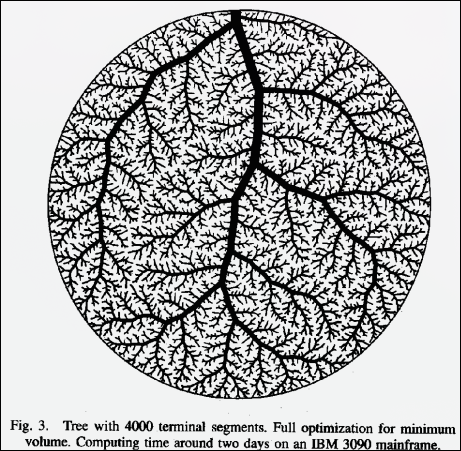

## 1.2 Descri√ß√£o do problema

Dada uma √°rvore arterial 2D com uma bifurca√ß√£o e com 3 segmentos, sendo um o pai, saindo do ponto de perfus√£o, os outros dois s√£o segmentos terminais. O problema consiste em encontrar um ponto no plano cartesiano para a bifurca√ß√£o em que o volume intravascular total da √°rvore seja o menor poss√≠vel. Para tal, ser√£o utilizados os limites cartesianos apresentados em **[2]** para encontrar o ponto √≥timo para a bifurca√ß√£o.

## 1.3 Objetivos

Encontrar um ponto em um plano cartesiano para a bifurca√ß√£o em que o volume intravascular total da √°rvore arterial seja o menor poss√≠vel e em menor que o algoritmo classico de otimiza√ß√£o baseada em gradiente.

# 2. Fundamenta√ß√£o Te√≥rica


Para calcular o volume intravascular total da √°rvore, dever√° ser usada a seguinte equa√ß√£o:

\begin{equation}\label{EQ: volume intravascular}
        V = \pi \sum_{i=1}^{K_{\text{tot}}} l_i r^2_i
\end{equation}

sendo $ k_{\textit{tot}} $ o n√∫mero total de segmentos, $l_i$ e $r_i$ s√£o respectivamente o comprimento e o raio do segmento $ i $.

In [159]:
def calcVolume(segmentos: list[dict]) -> float:
    volume = 0.0
    for seg in segmentos:
      volume += seg['comprimento'] * seg['raio']**2

    return volume * math.pi

Para tal, ser√° necess√°rio calcular o comprimento e o raio dos segmentos. Inicialmente deve se calcular o comprimento a partir da seguinte equa√ß√£o:

\begin{equation}\label{EQ: comprimento do segmento}
        L_a = \sqrt{(X_p - X_b)^2 + (Y_p - Y_b)^2},
        L_b = \sqrt{(X_f^1 - X_b)^2 + (Y_f^1 - Y_p)^2},
        L_c = \sqrt{(X_f^2 - X_b)^2 + (Y_f^2 - Y_p)^2}
\end{equation}

In [160]:
def calcComprimento(begin: list[float], end: list[float]) -> float:
    return np.linalg.norm(np.subtract(begin, end)) # Calcula a norma euclidiana (dist√¢ncia entre pontos).

Para encontrar os raios dos segmentos deve se seguir alguns passos para encontr√°-los. Inicialmente deve se calcular a resist√™ncia hidrodin√¢mica relativa ($R*$) de cada segmento, que √© uma vers√£o reduzida da resist√™ncia hidrodin√¢mica ($R$), que √© dada pela lei de Poiseuille [1]. Para encontrar ($R*$) deve se utilizar a seguinte equa√ß√£o:

\begin{equation}\label{EQ: Resist√™ncia hidrodin√¢mica}
        R_i = \left( \frac{8 \eta}{\pi} \right) \frac{l_i}{r^4_i}
\end{equation}

\begin{equation}\label{EQ: Resist√™ncia hidrodin√¢mica Relativa}
        R_i* = R_i {r^4_i},
        R_i* = \left( \frac{8 \eta}{\pi} \right) l_i
\end{equation}

Em que $ \eta $ representa a viscosidade sangu√≠nea ($ \eta = 3.6 cP$).

In [161]:
def calcResistenciaRelativa(comprimento: float, viscosidade: float = 0.0036) -> float:
    return (8 * viscosidade) / (math.pi * comprimento)

def CalcResistencia(resistenciaRelativa: float, raio: float) -> float:
    return resistenciaRelativa * raio**4

Ap√≥s, deve-se calcular o raio relativo do segmento B e C $ (\frac{r_b}{r_c}$), que podem ser encontrados pela equa√ß√£o:

\begin{equation}\label{EQ: Raio Relativo}
        \frac{r_b}{r_c} = (\frac{R_b*}{R_c*})^\frac{1}{4}
\end{equation}


In [162]:
def calcRaioRelativo(resistenciaRelativa_esq: float, resistenciaRelativa_dir: float) -> float:
  return (resistenciaRelativa_esq / resistenciaRelativa_dir)**(1/4)

Tendo os raios relativos √© poss√≠vel calcular a raz√£o da bifurca√ß√£o dos segmentos filhos de A ($ \beta^{esq}_a $ e $ \beta^{dir}_a $) pela equa√ß√£o:

\begin{equation}\label{EQ: bifurca√ß√£o relativa}
    \beta^{dir}_a = [1 + (\frac{r_b}{r_c})^\gamma]^{-\frac{1}{\gamma}},
    \beta^{esq}_a = [1 + (\frac{r_b}{r_c})^{-\gamma}]^{-\frac{1}{\gamma}}
\end{equation}

Em que o expoente $ \gamma $ que √© a constante de bifurca√ß√£o ($ \gamma \in [2.55;3] $).

In [163]:
def calcRazaoBirfucacao_dir(raioRelativo: float,  gamma: float = 3.0) -> float:
    return (1 + raioRelativo **gamma) **(-1/gamma)

def calcRazaoBirfucacao_esq(raioRelativo: float, gamma: float = 3.0) -> float:
    return (1 + raioRelativo **(-gamma)) **(-1/gamma)

Apos calcular a raz√£o de bifurca√ß√£o dos segmentos filhos de A pode se calcular a resist√™ncia hidrost√°tica relativa da √°rvore, para isso ser√° usado a seguinte equa√ß√£o:

\begin{equation}\label{EQ: resistencia arvore}
    R^*_{\textit{sub a}} = R^*_a + \left[ \frac{(\beta^{esq}_a)^4}{R^*_{\textit{b}}} + \frac{(\beta^{dir}_a)^4}{R^*_{\textit{c}}} \right]^{-1}
\end{equation}

In [164]:
def calcResistenciaRelativa_sub(resistenciaRelativa_pai: float, resistenciaRelativa_esq: float, resistenciaRelativa_dir: float,
                               razaoBirfucacao_esq: float, razaoBirfucacao_dir: float) -> float:
    razao_esq = razaoBirfucacao_esq**4/resistenciaRelativa_esq
    razao_dir = razaoBirfucacao_esq**4/resistenciaRelativa_dir
    return resistenciaRelativa_pai + (razao_esq + razao_dir)**(-1)

Tendo a resist√™ncia hidrost√°tica relativa da √°rvore, pode-se calcular o raio de A ($r_a$) a partir da seguinte equa√ß√£o:

\begin{equation}\label{EQ: raio raiz}
    r_a = (R^*_{\textit{sub a}} \frac{Q_{\textit{perf}}}{P_{\textit{perf}} - P_{\textit{term}}}) ^ {\frac{1}{4}}
\end{equation}

Sendo $ Q_{\textit{perf}} $ o fluxo de entrada, $ P_{\textit{perf}} $ a press√£o de entrada e $ P_{\textit{term}} $ a press√£o de saida.

In [165]:
def calcRaio_pai(resistenciaRelativa_sub: float, pressaoDiff: float, fluxo: float) -> float:
    return (resistenciaRelativa_sub * fluxo/pressaoDiff) **(1/4)

Apos encontrar o $r_a$ √© possivel calcular o raios dos proximos segmentos usando as equa√ß√µes.

\begin{equation}\label{EQ: raios restantes}
    \beta^{dir}_a = \frac{r_c}{r_a},
    \beta^{esq}_a = \frac{r_b}{r_a}
\end{equation}

In [166]:
def calcRaio_dir(raio_pai: float, razaoBirfucacao_dir: float) -> float:
    return razaoBirfucacao_dir * raio_pai

def calcRaio_esq(raio_pai: float, razaoBirfucacao_esq: float) -> float:
    return razaoBirfucacao_esq * raio_pai


# 3. Materiais e M√©todos

## 3.1 Estrutura da √Årvore

Como o objetivo desse trabalho √© validar uma solu√ß√£o evolutiva para a otimiza√ß√£o geometrica do m√©todo CCO, a √°rvore 2D a ser gerada tera somente 3 segmentos, com o ponto de perfus√£o e os dois pontos terminais fixos, variando somente o ponto de bifurca√ß√£o. O poto de perfus√£o ser√° $ Point_{perf}(0, 5)$ e os pontos terminais ser√£o $ Point_{term}esq(-3.54, -1.46)$ e $ Point_{term}dir(3.54, -1.46)$, o $Point_{birf}$ ir√° variar.

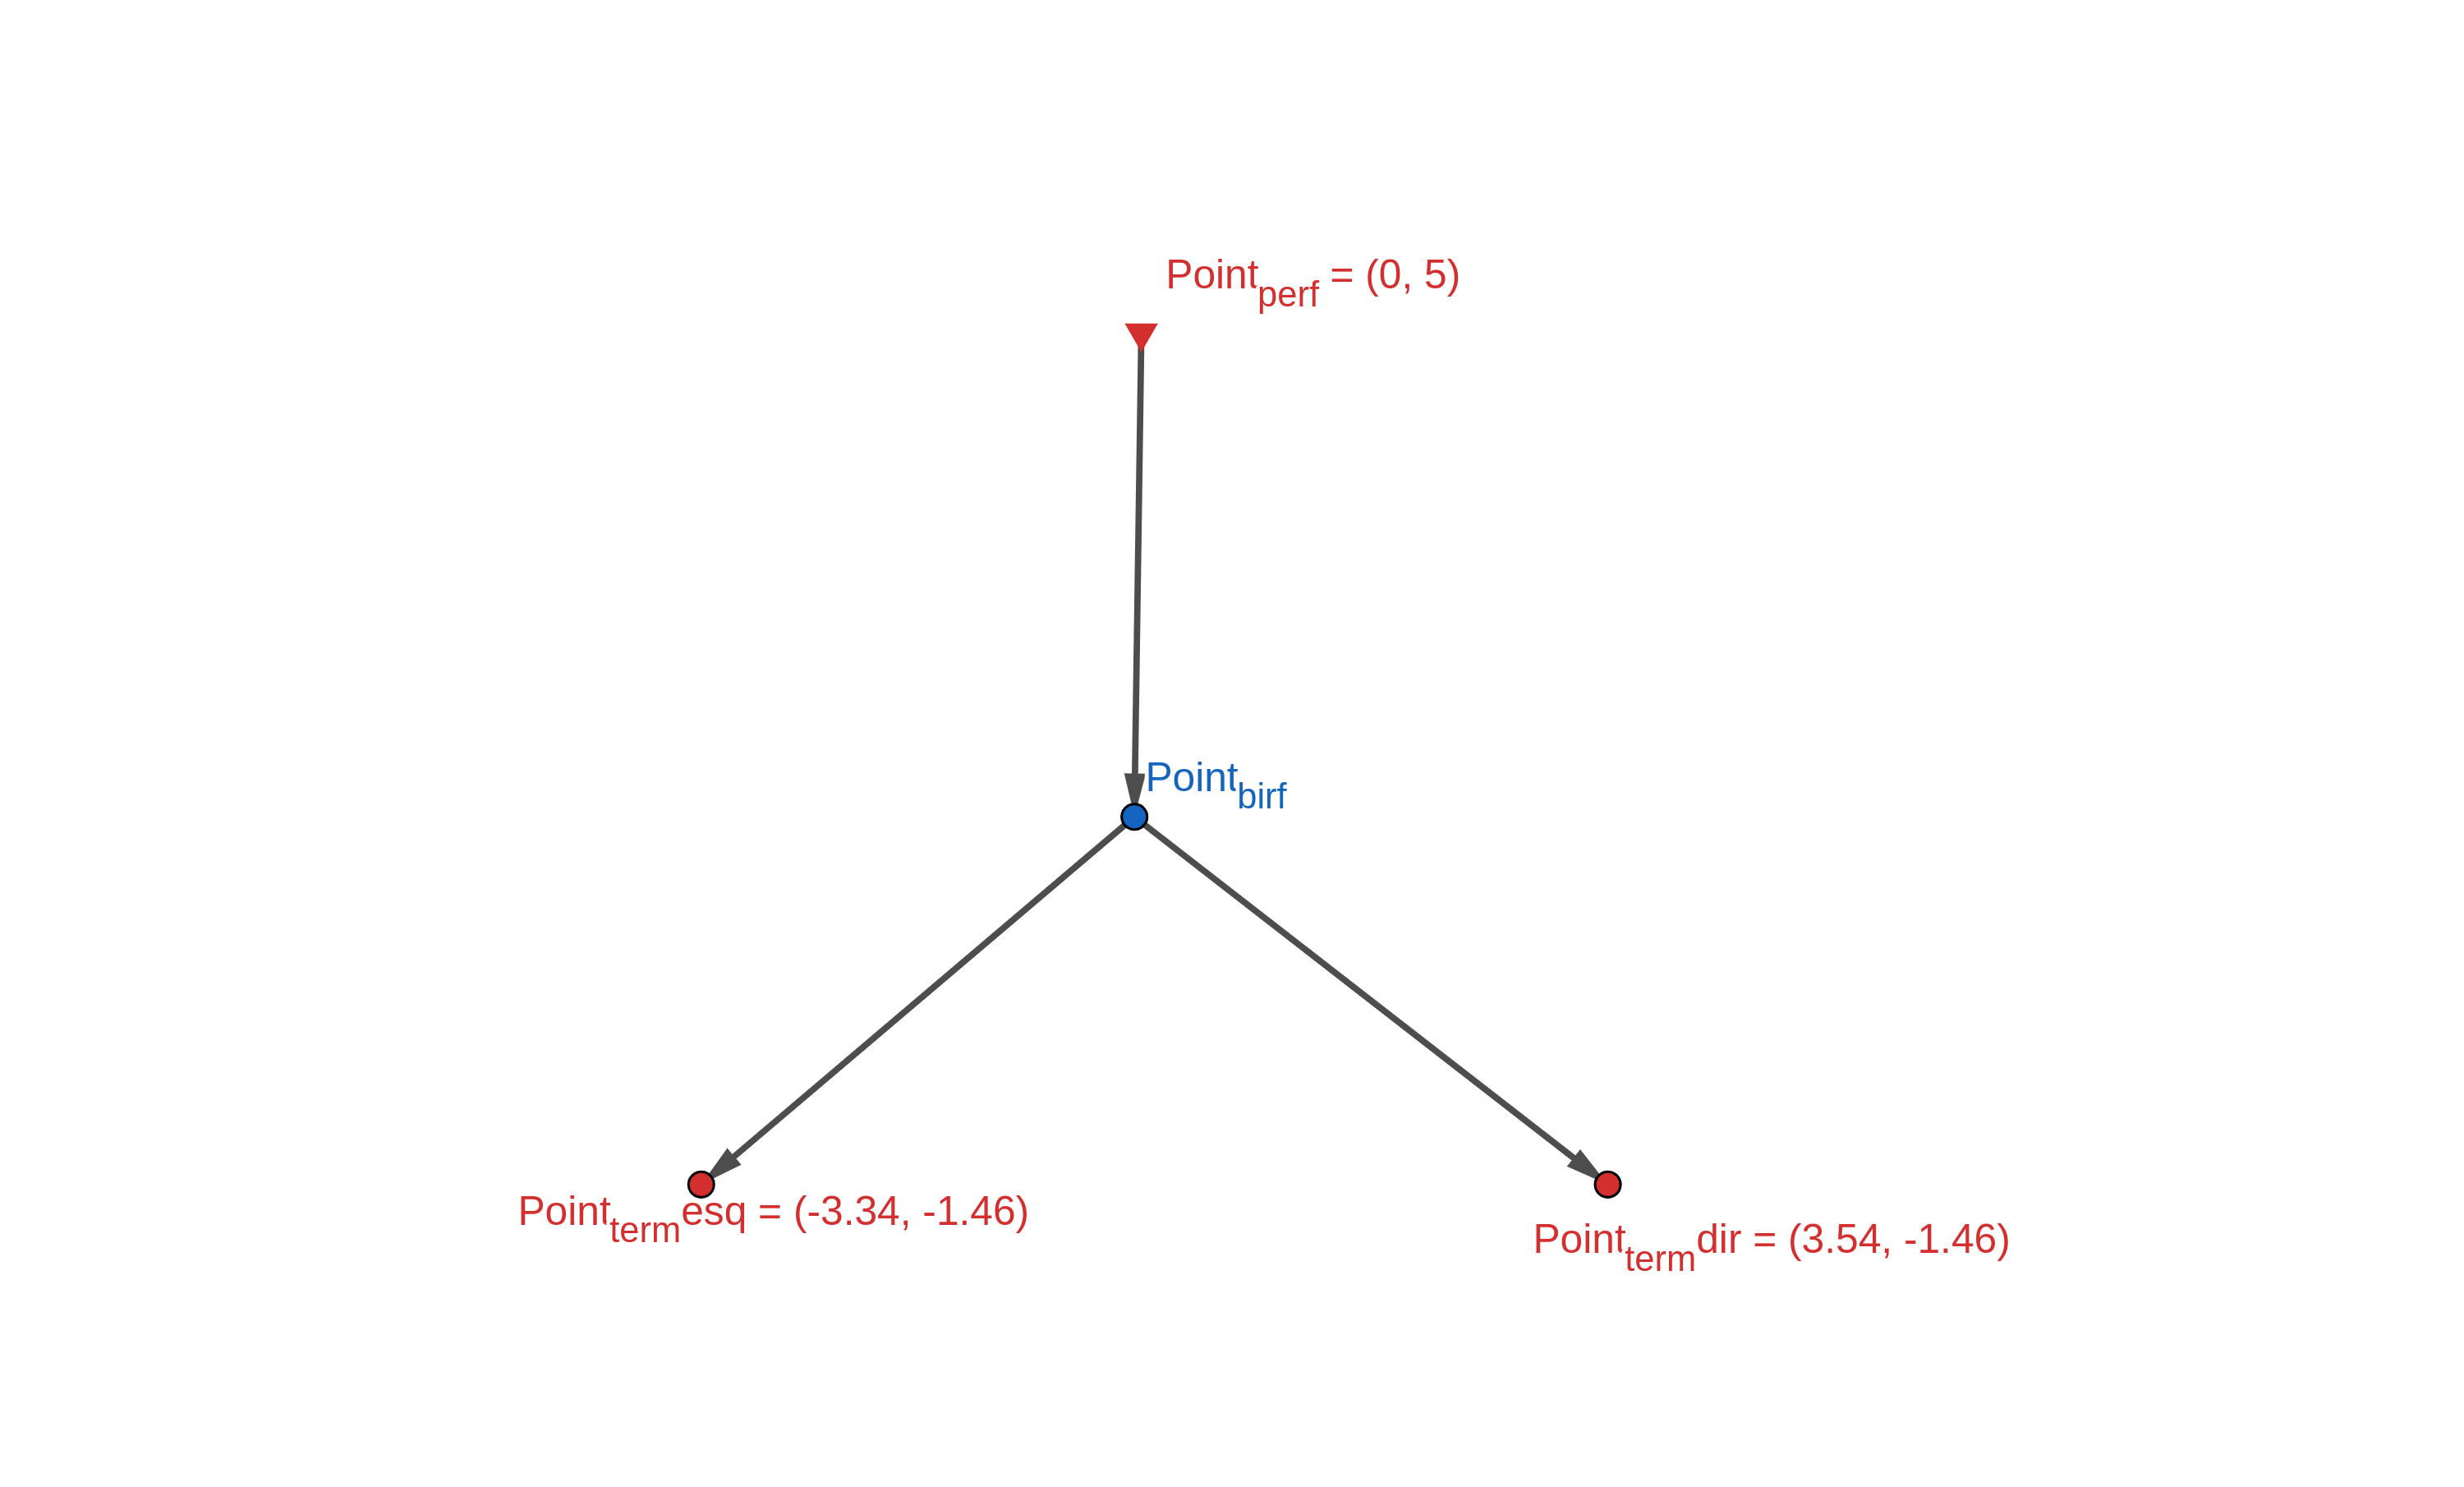

In [167]:
POINT_PERF = [0.00, 5.00]
POINT_TERM_ESQ = [-3.54, -1.46]
POINT_TERM_DIR = [3.54, -1.46]

X_MIN = min(POINT_PERF[0], POINT_TERM_ESQ[0], POINT_TERM_DIR[0])
X_MAX = max(POINT_PERF[0], POINT_TERM_ESQ[0], POINT_TERM_DIR[0])
Y_MIN = min(POINT_PERF[1], POINT_TERM_ESQ[1], POINT_TERM_DIR[1])
Y_MAX = max(POINT_PERF[1], POINT_TERM_ESQ[1], POINT_TERM_DIR[1])

Para auxiliar na busca do resultado √≥timo √© mister delimitar o espa√ßo de busca. Para tal, ser√° tomado como hip√≥tese que o ponto √≥timo para a bifurca√ß√£o est√° dentro do triangulo formado pelos v√©rtices $Point_{perf}$,  $Point_{term}esq$ e  $Point_{term}dir$.

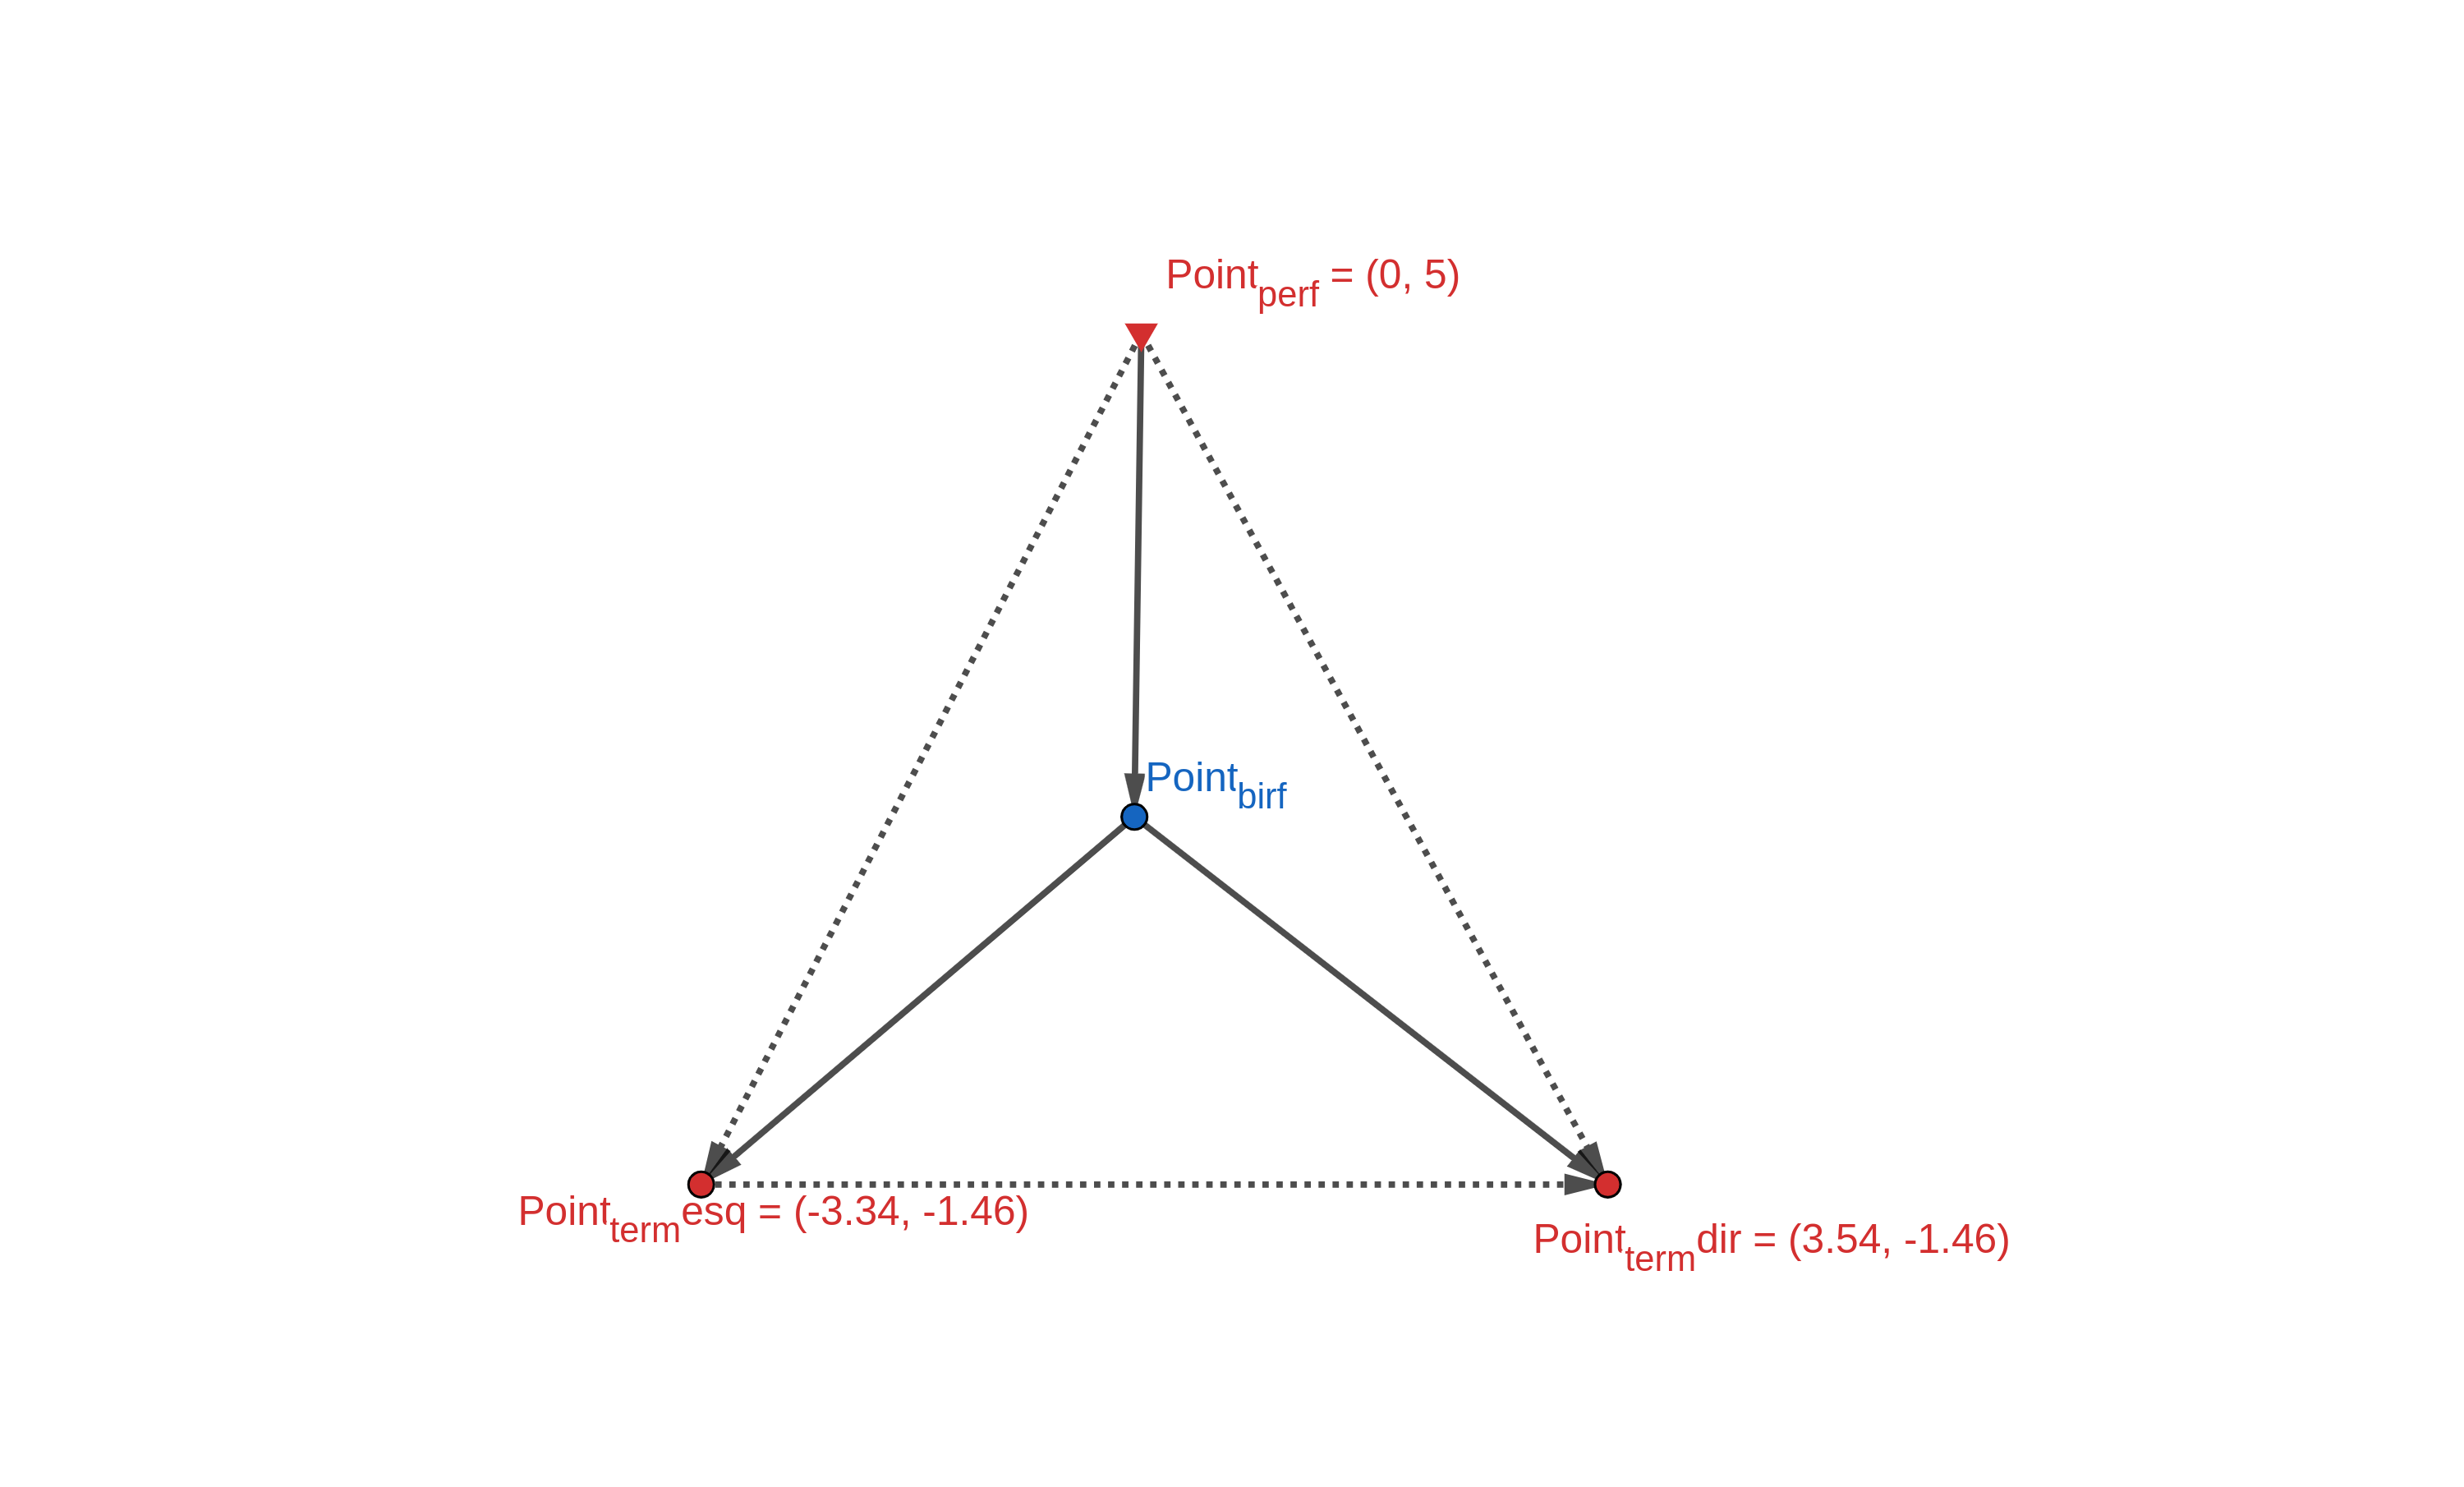

Para que isso ocorra a soma das √°reas dos triangulos $(Point_{term}esq, Point_{term}dir, Point_{birf})$, $(Point_{term}esq, Point_{perf}, Point_{birf})$ e $(Point_{term}dir, Point_{perf}, Point_{birf})$ ter√° de ser igual a √°rea do triangulo $( Point_{perf}, Point_{term}esq, Point_{term}dir)$.

In [168]:
def validaBirfucacao(pointBirf: list[float]) -> bool:

    if (pointBirf[0] < X_MIN or pointBirf[0] > X_MAX) or (pointBirf[1] < Y_MIN or pointBirf[1] > Y_MAX):
        return False

    def area_triangulo(a, b, c):
        return 0.5 * abs(a[0] * (b[1] - c[1]) +
                         b[0] * (c[1] - a[1]) +
                         c[0] * (a[1] - b[1]))

    area_original = area_triangulo(POINT_PERF, POINT_TERM_ESQ, POINT_TERM_DIR)

    area1 = area_triangulo(pointBirf, POINT_TERM_ESQ, POINT_TERM_DIR)
    area2 = area_triangulo(pointBirf, POINT_PERF, POINT_TERM_DIR)
    area3 = area_triangulo(pointBirf, POINT_TERM_ESQ, POINT_PERF)

    # Compara√ß√£o com toler√¢ncia para evitar erros de ponto flutuante
    return math.isclose(area_original, (area1 + area2 + area3), rel_tol=1e-9)

Alem de definir os parametros estruturais, precisamos definir alguns parametros fisiologicos da √°rvore a ser modeladas. Dentro os parametro est√£o a press√£o de perfus√£o e terminal $P_{perf} = 70 mmHg$ ou $9332,57Pa$ e $P_{term} = 30mmHg$ ou $3999,67Pa$, o fluxo $Q_{perf} = 0,2244L/min$ ou $3,74e^{-6}m¬≥/s$, a viscosidade do sangue $ \eta = 3.6cP$ ou $0.0036Pa.s$ e o coeficiente de bifurca√ß√£o $ \gamma = 3 $.

In [169]:
P_PERF = 9332.57
P_TERM = 3999.67
Q_PERF = 3.74e-6
VISCOSIDADE = 0.0036
GAMMA = 3

Dadas as equa√ß√µes do m√©todo CCO e os par√¢metros fisiol√≥gicos e topol√≥gicos estabelecidos, podemos definir a seguinte fun√ß√£o, que calcular√° e retornar√° o volume intravascular total da √°rvore para um ponto de bifurca√ß√£o espec√≠fico, fornecido como par√¢metro.

In [170]:
def calVolumeTotal(pontoBirf: list[float], pontoPerf: list[float] = POINT_PERF, pontoTerm_esq: list[float] = POINT_TERM_ESQ,
                   pontoTerm_dir: list[float] = POINT_TERM_DIR, pressaoDiff: float = (P_PERF - P_TERM), fluxo: float = Q_PERF,
                   gamma: float = GAMMA, viscosidade: float = VISCOSIDADE) -> float:

    # Calcula os comprimentos e resistencias relativas
    segmento_pai = {}
    segmento_pai["comprimento"] = calcComprimento(pontoPerf, pontoBirf)
    segmento_pai["resistencia_relativa"] = calcResistenciaRelativa(segmento_pai["comprimento"], viscosidade)

    segmento_esq = {}
    segmento_esq["comprimento"] = calcComprimento(pontoBirf, pontoTerm_esq)
    segmento_esq["resistencia_relativa"] = calcResistenciaRelativa(segmento_esq["comprimento"], viscosidade)

    segmento_dir = {}
    segmento_dir["comprimento"] = calcComprimento(pontoBirf, pontoTerm_dir)
    segmento_dir["resistencia_relativa"] = calcResistenciaRelativa(segmento_dir["comprimento"], viscosidade)

    # Calcula os raios relativos e raz√£o de birfurca√ß√£o
    raio_relativo = calcRaioRelativo(segmento_esq["resistencia_relativa"], segmento_dir["resistencia_relativa"])
    razao_birf_esq = calcRazaoBirfucacao_esq(raio_relativo, gamma)
    razao_birf_dir = calcRazaoBirfucacao_dir(raio_relativo, gamma)

    # Calcula a resistencia relativa da sub arvore do segmento pai
    resistencia_relativa_sub = calcResistenciaRelativa_sub(segmento_pai["resistencia_relativa"], segmento_esq["resistencia_relativa"],
                                                           segmento_dir["resistencia_relativa"], razao_birf_esq, razao_birf_dir)

    # Calcula os raios
    segmento_pai["raio"] = calcRaio_pai(resistencia_relativa_sub, pressaoDiff, fluxo)
    segmento_esq["raio"] = calcRaio_esq(segmento_pai["raio"], razao_birf_esq)
    segmento_dir["raio"] = calcRaio_dir(segmento_pai["raio"], razao_birf_dir)

    segmentos = [segmento_pai, segmento_esq, segmento_dir]

    # Calcula o Volume total e
    return float(calcVolume(segmentos) * 100000) # Convertendo para e‚Åª‚Åµ mm¬≥


Para uma melhor an√°lise da fun√ß√£o de fitness, foi gerado um gr√°fico 3D que representa a varia√ß√£o do volume total em fun√ß√£o das coordenadas da bifurca√ß√£o. A superf√≠cie foi colorida de acordo com os valores de volume, onde tons mais escuros indicam menores volumes e tons mais claros representam volumes maiores. Al√©m disso, o ponto correspondente ao menor volume encontrado foi destacado em vermelho, facilitando a visualiza√ß√£o da solu√ß√£o √≥tima dentro da regi√£o v√°lida de bifurca√ß√£o.

<ipython-input-161-71121be2c205>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (8 * viscosidade) / (math.pi * comprimento)


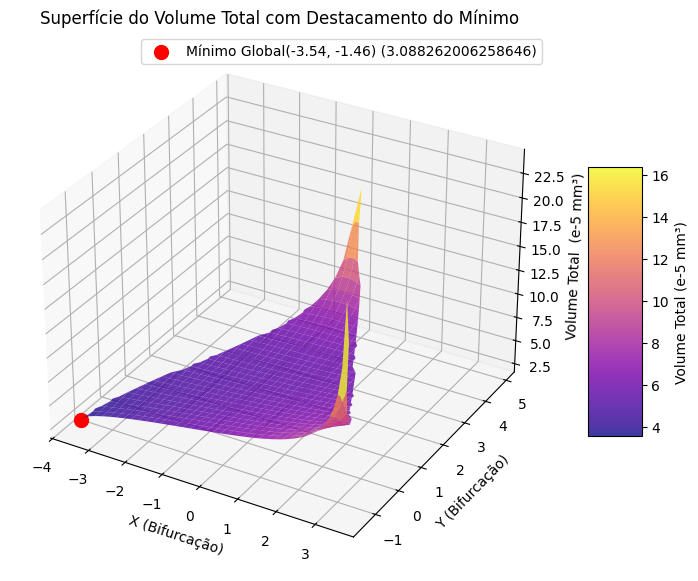

In [194]:
# Criar uma grade de pontos
x_range = np.arange(X_MIN, X_MAX, 0.1)
y_range = np.arange(Y_MIN, Y_MAX, 0.1)
X, Y = np.meshgrid(x_range, y_range)

# Criar a matriz de volumes, inicializando com NaN para pontos inv√°lidos
Z = np.full_like(X, np.nan)

# Percorre a grade e calcula o volume apenas para pontos v√°lidos
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x, y = X[i, j], Y[i, j]
        if validaBirfucacao([x, y]):  # Apenas para pontos v√°lidos
            Z[i, j] = calVolumeTotal([[x, y]])

# Encontrar o ponto com menor volume
min_idx = np.unravel_index(np.nanargmin(Z), Z.shape)
x_min_vol, y_min_vol, min_vol = X[min_idx], Y[min_idx], Z[min_idx]

# Criando a figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Criando um mapa de cores com base nos valores de volume
surf = ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none', alpha=0.8)

# Adicionar ponto m√≠nimo destacado
ax.scatter(x_min_vol, y_min_vol, min_vol, color='red', s=100, label=f"M√≠nimo Global{(float(x_min_vol), float(y_min_vol))} ({min_vol})")

# Adicionando uma barra de cores para refer√™ncia
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label("Volume Total (e-5 mm¬≥)")  # Ajustando o r√≥tulo da barra de cores

# Configura√ß√µes do gr√°fico
ax.set_xlabel("X (Bifurca√ß√£o)")
ax.set_ylabel("Y (Bifurca√ß√£o) ")
ax.set_zlabel("Volume Total  (e-5 mm¬≥)")
ax.set_title("Superf√≠cie do Volume Total com Destacamento do M√≠nimo")
ax.legend()

plt.show()

O gr√°fico 3D representa a varia√ß√£o do volume total em fun√ß√£o das coordenadas X e Y da bifurca√ß√£o, onde a colora√ß√£o da superf√≠cie indica diferentes magnitudes de volume. A escala de cores mostra que valores menores de volume s√£o representados por tons mais escuros (roxos), enquanto volumes maiores aparecem em tons mais claros (amarelos). O ponto de volume m√≠nimo global est√° destacado em vermelho, localizado em (‚àí3.54,‚àí1.46), indicando a posi√ß√£o √≥tima para minimizar o volume total dentro da regi√£o v√°lida de bifurca√ß√£o. A superf√≠cie apresenta uma inclina√ß√£o acentuada em certas regi√µes, sugerindo uma alta sensibilidade do volume em rela√ß√£o √†s mudan√ßas na posi√ß√£o da bifurca√ß√£o.

## 3.2 benchmark

A otimiza√ß√£o baseada em gradiente √© um m√©todo iterativo que ajusta os par√¢metros de uma fun√ß√£o deslocando-se na dire√ß√£o do gradiente para minimizar ou maximizar um valor objetivo. Esse m√©todo √© amplamente utilizado em problemas de otimiza√ß√£o cont√≠nua, especialmente quando a fun√ß√£o √© diferenci√°vel, permitindo ajustes eficientes dos par√¢metros para encontrar valores √≥timos.

Dado que os trabalhos [1, 3] apresentam a otimiza√ß√£o geom√©trica utilizando um algoritmo baseado em gradiente, este mesmo m√©todo ser√° empregado como benchmark para avaliar o desempenho do algoritmo evolutivo.

Itera√ß√£o 10: x = -0.207341, y = 0.118852, volume = 5.57836696, grad_norm = 4.562175e-01, learning_rate = 0.050000
Itera√ß√£o 20: x = -0.402719, y = 0.212466, volume = 5.48480814, grad_norm = 4.162033e-01, learning_rate = 0.050000
Itera√ß√£o 30: x = -0.588768, y = 0.283557, volume = 5.40568919, grad_norm = 3.851709e-01, learning_rate = 0.050000
Itera√ß√£o 40: x = -0.767444, y = 0.334490, volume = 5.33679619, grad_norm = 3.617435e-01, learning_rate = 0.050000
Itera√ß√£o 50: x = -0.940256, y = 0.367278, volume = 5.27500989, grad_norm = 3.447509e-01, learning_rate = 0.050000
Itera√ß√£o 60: x = -1.108402, y = 0.383579, volume = 5.21798297, grad_norm = 3.331945e-01, learning_rate = 0.050000
Itera√ß√£o 70: x = -1.272858, y = 0.384706, volume = 5.16390666, grad_norm = 3.262555e-01, learning_rate = 0.050000
Itera√ß√£o 80: x = -1.434444, y = 0.371634, volume = 5.11133405, grad_norm = 3.233113e-01, learning_rate = 0.050000
Itera√ß√£o 90: x = -1.593877, y = 0.345000, volume = 5.05904039, grad_no

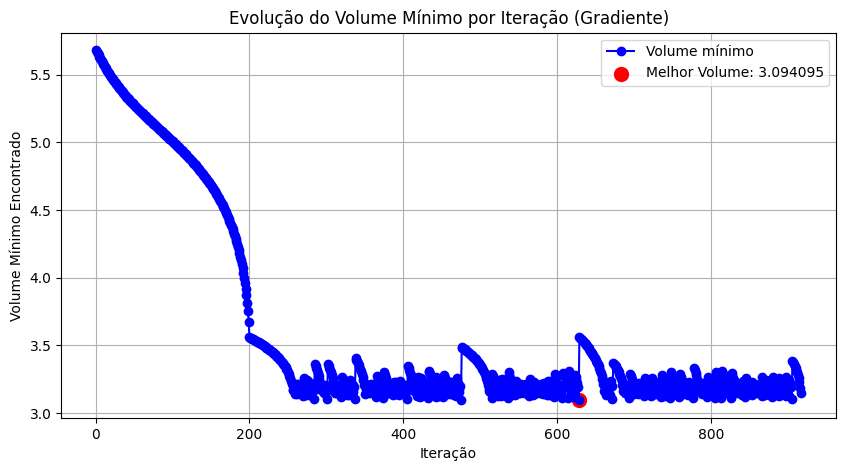

[5.67965476384456, 5.667428851847797, 5.655465178246333, 5.643755025947034, 5.632289985465842, 5.621061940815487, 5.610063056470152, 5.599285764972461, 5.588722755320939, 5.578366962009881, 5.568211554844493, 5.5582499291662755, 5.54847569679078, 5.538882677377044, 5.529464890064825, 5.520216545998707, 5.511132040742632, 5.502205947419544, 5.493433009986617, 5.484808137045079, 5.476326395621721, 5.467983005551058, 5.4597733339904675, 5.451692890064029, 5.443737320012877, 5.435902402153431, 5.42818404251559, 5.420578270176764, 5.413081233276611, 5.405689194600619, 5.398398527957945, 5.391205714234278, 5.384107337815698, 5.377100082928621, 5.370180730494551, 5.363346154638358, 5.356593319673316, 5.349919276963311, 5.343321161912069, 5.336796191226217, 5.330341660079327, 5.323954939486105, 5.317633473604627, 5.311374777263314, 5.305176433503489, 5.299036091258676, 5.292951462993656, 5.286920322464106, 5.280940502568149, 5.275009893246472, 5.269126439316568, 5.263288138598392, 5.2574930399

In [192]:
def optimizeBifurcationGeometry_gradient(x_start=None, y_start=None, learning_rate=0.05, max_iters=20000, tolerance=1e-6, plot=False, seed=42) -> float:
    random.seed(seed)

    # Gera valores aleat√≥rios at√© encontrar um ponto v√°lido
    def calcNovoPonto():
        while True:
            x = np.random.uniform(X_MIN, X_MAX)
            y = np.random.uniform(Y_MIN, Y_MAX)

            if validaBirfucacao([x, y]):
                return x, y

    # Define ponto inicial v√°lido
    if x_start is None or y_start is None:
        x, y = calcNovoPonto()
    else:
        x, y = x_start, y_start

    n_iters = 0
    volume_min = calVolumeTotal([[x, y]])  # Inicializa com o volume do primeiro ponto
    last_volume = volume_min
    n_iters_invalid = 0
    stagnant_iters = 0  # Contador para detectar estagna√ß√£o
    volume_history = []  # Armazena a evolu√ß√£o do volume m√≠nimo

    for _ in range(max_iters):
        # Calcula a Gradiente
        v1 = calVolumeTotal([[x + tolerance, y]])
        v2 = calVolumeTotal([[x, y]])
        v3 = calVolumeTotal([[x, y + tolerance]])

        grad_x = (v1 - v2) / tolerance
        grad_y = (v3 - v2) / tolerance
        grad_norm = np.sqrt(grad_x**2 + grad_y**2)

        # Ajuste din√¢mico da learning rate
        if volume_min > 3.8:
            learning_rate = min(learning_rate * 1.02, 0.05)  # Aumenta se ainda est√° longe do √≥timo
        elif volume_min < 3.6:
            learning_rate = max(learning_rate * 0.9, 0.001)  # Reduz para refinamento perto do √≥timo

        # Calcula e valida a proxima coordenada
        x_new = x - learning_rate * grad_x
        y_new = y - learning_rate * grad_y

        if not validaBirfucacao([x_new, y_new]):
            if n_iters_invalid > 25:  # Se travar em coordenadas inv√°lidas, ele sorteia novas
                x, y = calcNovoPonto()
                n_iters_invalid = 0
            else:
                n_iters_invalid += 1
                continue

        n_iters_invalid = 0

        # Atualiza as coordenadas e o volume
        x, y = x_new, y_new
        n_iters += 1
        volume_min = calVolumeTotal([[x, y]])

        # Armazena o volume m√≠nimo da itera√ß√£o atual
        volume_history.append(volume_min)

        # Exibe progresso a cada 500 itera√ß√µes
        if plot and n_iters % 10 == 0:
            print(f"Itera√ß√£o {n_iters}: x = {x:.6f}, y = {y:.6f}, volume = {volume_min:.8f}, grad_norm = {grad_norm:.6e}, learning_rate = {learning_rate:.6f}")

        # Detecta estagna√ß√£o e reinicia a otimiza√ß√£o se necess√°rio
        if abs(volume_min - last_volume) < 1e-8:
            stagnant_iters += 1
        else:
            stagnant_iters = 0  # Reseta se houver progresso

        last_volume = volume_min  # Atualiza o volume anterior para pr√≥xima itera√ß√£o

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(volume_history) + 1), volume_history, marker='o', linestyle='-', color='b', label="Volume m√≠nimo")

        # Destaca o menor volume encontrado
        min_volume = min(volume_history)
        min_idx = volume_history.index(min_volume) + 1
        plt.scatter(min_idx, min_volume, color='red', s=100, label=f"Melhor Volume: {min_volume:.6f}")

        plt.xlabel("Itera√ß√£o")
        plt.ylabel("Volume M√≠nimo Encontrado")
        plt.title("Evolu√ß√£o do Volume M√≠nimo por Itera√ß√£o (Gradiente)")
        plt.legend()
        plt.grid()
        plt.show()

    return volume_history

print(optimizeBifurcationGeometry_gradient(0, 0, plot=True))

Par√¢metros:
- x_start, y_start: Ponto inicial (se None, √© gerado aleatoriamente)
- learning_rate: Taxa de aprendizado para descida do gradiente
- max_iters: N√∫mero m√°ximo de itera√ß√µes
- tolerance: Crit√©rio de converg√™ncia baseado no gradiente
- volume_tolerance: Precis√£o para considerar o volume m√≠nimo atingido
- plot: Se True, imprime o grafico e o volume minimo da gera√ß√£o a cada 10
- seed: Seed para gera√ß√£o de valores aleatorios

Retorna:
- volume_history: Uma lista com todos os volumes minimos calculados.

A fun√ß√£o *optimize_bifurcation_geometry* utiliza descida do gradiente para minimizar o volume intravascular total de uma √°rvore arterial, ajustando dinamicamente a posi√ß√£o da bifurca√ß√£o. Inicialmente, se um ponto (x, y) v√°lido n√£o for fornecido, ele √© gerado aleatoriamente dentro dos limites permitidos. A cada itera√ß√£o, a fun√ß√£o calcula a gradiente do volume e ajusta (x, y) na dire√ß√£o de menor volume. A taxa de aprendizado (*learning_rate*) √© ajustada dinamicamente: aumenta quando o volume est√° longe do √≥timo e diminui perto do m√≠nimo para maior precis√£o. O processo para quando o n√∫mero m√°ximo de itera√ß√µes (max_iters) √© atingido. A fun√ß√£o retorna uma lista com todos os volumes minimos calculados.

## 3.2 Deap e configura√ß√µes

A otimiza√ß√£o evolutiva √© uma abordagem baseada em algoritmos gen√©ticos, onde uma popula√ß√£o de solu√ß√µes √© evolu√≠da ao longo de m√∫ltiplas gera√ß√µes. Diferentemente da otimiza√ß√£o baseada em gradiente, os algoritmos evolutivos s√£o capazes de escapar de m√≠nimos locais e encontrar solu√ß√µes globais sem a necessidade de derivadas da fun√ß√£o objetivo.

Este cap√≠tulo descreve a implementa√ß√£o de um algoritmo evolutivo usando a biblioteca DEAP (Distributed Evolutionary Algorithms in Python), com o objetivo de minimizar o volume intravascular total de uma √°rvore arterial, ajustando dinamicamente a posi√ß√£o da bifurca√ß√£o.

### 3.2.1 Representa√ß√£o da solu√ß√£o

Cada indiv√≠duo na popula√ß√£o representa um poss√≠vel ponto de bifurca√ß√£o na forma de um par de coordenadas (x, y).

Os valores de x e y s√£o cont√≠nuos e devem respeitar os seguintes limites:
X: [-3.54, 3.54]
Y: [-1.46, 5.00]

Cada ponto gerado deve ser validado pela fun√ß√£o validaBirfucacao([x, y]), garantindo que apenas pontos vi√°veis sejam considerados na otimiza√ß√£o. Se um ponto inv√°lido for gerado, um novo √© escolhido aleatoriamente.

In [173]:
def create_valid_individual():
    while True:
        x = random.uniform(X_MIN, X_MAX)
        y = random.uniform(Y_MIN, Y_MAX)
        if validaBirfucacao([x, y]):
            return deap.creator.Individual([x, y])

### 3.2.2 Fun√ß√£o de Avalia√ß√£o (Fitness)

A fun√ß√£o de avalia√ß√£o mede a qualidade de cada indiv√≠duo com base no volume intravascular total, retornando um √∫nico valor (menor √© melhor).

In [174]:
def evaluate(individual):
    x, y = individual
    return (calVolumeTotal([[x, y]]),)

Entrada: Um indiv√≠duo (x, y).

Sa√≠da: O volume total em (e-5 mm¬≥).

### 3.2.3 Inicializa√ß√£o da Popula√ß√£o

A popula√ß√£o inicial cont√©m pop_size indiv√≠duos, onde cada um √© gerado aleatoriamente dentro dos limites de x e y.

In [175]:
toolbox = deap.base.Toolbox()
toolbox.register("evaluate", evaluate)
toolbox.register("individual", create_valid_individual)
toolbox.register("population", deap.tools.initRepeat, list, toolbox.individual)

### 3.2.4 Operadores Evolutivos

**Sele√ß√£o**: Torneio (tools.selTournament)

Um valor 3 foi escolhido por manter a diversidade, enquanto um valor muito alto faria o algoritmo convergir rapidamente para um √≥timo local.

In [176]:
toolbox.register("select", deap.tools.selTournament, tournsize=3)

 **Cruzamento**: tools.cxBlend (Œ± = 0.5)

Como x e y s√£o valores cont√≠nuos, um cruzamento uniforme seria ineficaz, por tanto, o cxBlend foi escolhido por manter a varia√ß√£o gen√©tica sem criar valores extremos. O valor de alfa escolhido foi 0.5 por d√° pesos iguais a ambos os pais durante a mistura os genes dos pais.




In [177]:
toolbox.register("mate", deap.tools.cxBlend, alpha=0.5)

**Muta√ß√£o**: tools.mutGaussian

A muta√ß√£o adiciona varia√ß√£o aleat√≥ria para evitar que a popula√ß√£o fique presa em m√≠nimos locais, o que pode ocorrer na otimiza√ß√£o gradiente.

Par√¢metros:
  - mu=0: M√©dia da perturba√ß√£o √© zero (mant√©m o ponto pr√≥ximo).

  - sigma = 0.2: Desvio padr√£o da muta√ß√£o (define o qu√£o longe um gene pode ser alterado).

  - indpb = 0.5: Cada vari√°vel (x ou y) tem 50% de chance de sofrer muta√ß√£o.

In [178]:
toolbox.register("mutate", deap.tools.mutGaussian, mu=0, sigma=0.2, indpb=0.5)

Usando as configura√ß√µes apresentadas, a fun√ß√£o *optimizeBifurcationGeometry_evolution* implementa um algoritmo evolutivo para encontrar a bifurca√ß√£o arterial √≥tima, minimizando o volume total da √°rvore. O processo inicia com uma popula√ß√£o de solu√ß√µes geradas aleatoriamente e, ao longo de m√∫ltiplas gera√ß√µes, evolui aplicando sele√ß√£o, cruzamento e muta√ß√£o, permitindo uma explora√ß√£o eficiente do espa√ßo de busca. A cada gera√ß√£o, o melhor volume encontrado √© armazenado e pode ser visualizado graficamente, possibilitando o monitoramento da converg√™ncia da solu√ß√£o. Essa abordagem possibilita uma an√°lise comparativa com m√©todos baseados em gradiente, permitindo avaliar a efici√™ncia, robustez e estabilidade do algoritmo na otimiza√ß√£o da bifurca√ß√£o arterial.

Gera√ß√£o 0: Melhor Volume = 4.320961
Gera√ß√£o 10: Melhor Volume = 3.287117
Gera√ß√£o 20: Melhor Volume = 3.114272
Gera√ß√£o 30: Melhor Volume = 3.091967
Gera√ß√£o 40: Melhor Volume = 3.088687
Gera√ß√£o 50: Melhor Volume = 3.088326
Gera√ß√£o 60: Melhor Volume = 3.088269
Gera√ß√£o 70: Melhor Volume = 3.088263
Gera√ß√£o 80: Melhor Volume = 3.088262


<ipython-input-161-71121be2c205>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (8 * viscosidade) / (math.pi * comprimento)


Gera√ß√£o 90: Melhor Volume = 3.088262
Gera√ß√£o 100: Melhor Volume = 3.088262
Gera√ß√£o 110: Melhor Volume = 3.088262
Gera√ß√£o 120: Melhor Volume = 3.088262
Gera√ß√£o 130: Melhor Volume = 3.088262
Gera√ß√£o 140: Melhor Volume = 3.088262
Gera√ß√£o 150: Melhor Volume = 3.088262
Gera√ß√£o 160: Melhor Volume = 3.088262
Gera√ß√£o 170: Melhor Volume = 3.088262
Gera√ß√£o 180: Melhor Volume = 3.088262
Gera√ß√£o 190: Melhor Volume = 3.088262

üîπ Finalizado ap√≥s 200 gera√ß√µes. Melhor volume: 3.088262


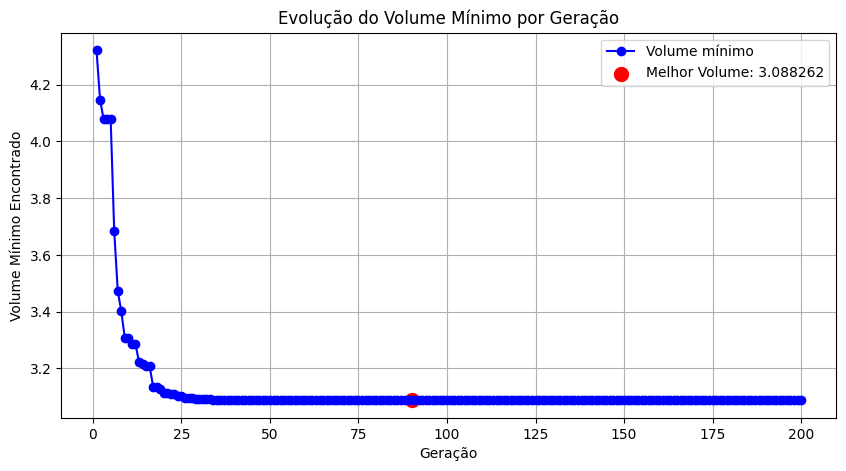

-3.54 -1.46 3.088262006258646 200
[4.320961242772243, 4.1473933342246285, 4.078627395633862, 4.078627395633862, 4.078627395633862, 3.684572667368246, 3.473516005066138, 3.4012199806837553, 3.3072208532260325, 3.3072208532260325, 3.287117498597577, 3.287117498597577, 3.2226720731493055, 3.216990759435314, 3.20765296458052, 3.20765296458052, 3.1363877885215623, 3.1363877885215623, 3.129252263386318, 3.11427189047129, 3.11427189047129, 3.1110810072787425, 3.1110810072787425, 3.103287698743389, 3.103287698743389, 3.096845345037147, 3.096845345037147, 3.0946487617985667, 3.0923808637415715, 3.091967323341035, 3.091967323341035, 3.091110986018635, 3.091110986018635, 3.090154839798505, 3.08912561233142, 3.08912561233142, 3.08912561233142, 3.0886869473695224, 3.0886869473695224, 3.0886869473695224, 3.0886869473695224, 3.0884946562954636, 3.0884278586879588, 3.0884278586879588, 3.0884278586879588, 3.0884278586879588, 3.0884168013517193, 3.0884168013517193, 3.0884168013517193, 3.0883262618620964

In [189]:
def optimizeBifurcationGeometry_evolution(pop_size=100, cx_prob=0.7, mut_prob=0.2, max_generations=200, plot=False, seed=42) -> float:
    random.seed(seed)

    # Inicializa√ß√£o da Popula√ß√£o
    population = toolbox.population(n=pop_size)

    # Avalia√ß√£o Inicial
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Vari√°veis de controle
    best_volume = float('inf')
    best_individual = None
    volume_history = []  # Lista para armazenar os melhores volumes

    # Loop Evolutivo
    for gen in range(max_generations):
        # Sele√ß√£o dos Pais
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Cruzamento
        for child1, child2 in zip(offspring[::2], offspring[1::2]):  # Processa pares de indiv√≠duos
            if random.random() < cx_prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values  # Remove aptid√£o para for√ßar nova avalia√ß√£o

        # Muta√ß√£o
        for mutant in offspring:
            if random.random() < mut_prob:
                toolbox.mutate(mutant)
                del mutant.fitness.values  # Remove aptid√£o para for√ßar nova avalia√ß√£o

        # Avalia√ß√£o de novos indiv√≠duos
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Atualiza a popula√ß√£o
        population[:] = offspring

        # Obt√©m o melhor indiv√≠duo da gera√ß√£o
        current_best = min(population, key=lambda ind: ind.fitness.values[0])
        current_volume = current_best.fitness.values[0]

        # Atualiza o melhor volume e indiv√≠duo global
        if current_volume < best_volume:
            best_volume = current_volume
            best_individual = current_best

        # Armazena o volume m√≠nimo da gera√ß√£o atual
        volume_history.append(best_volume)

        # Exibe progresso a cada 10 gera√ß√µes
        if plot and gen % 10 == 0:
            print(f"Gera√ß√£o {gen}: Melhor Volume = {best_volume:.6f}")

    print(f"\nüîπ Finalizado ap√≥s {gen+1} gera√ß√µes. Melhor volume: {best_volume:.6f}")

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(volume_history) + 1), volume_history, marker='o', linestyle='-', color='b', label="Volume m√≠nimo")

        # Destaca o menor volume encontrado
        min_volume = min(volume_history)
        min_idx = volume_history.index(min_volume) + 1
        plt.scatter(min_idx, min_volume, color='red', s=100, label=f"Melhor Volume: {min_volume:.6f}")

        plt.xlabel("Gera√ß√£o")
        plt.ylabel("Volume M√≠nimo Encontrado")
        plt.title("Evolu√ß√£o do Volume M√≠nimo por Gera√ß√£o")
        plt.legend()
        plt.grid()
        plt.show()
        print(best_individual[0], best_individual[1], best_volume, gen+1)

    return volume_history

# Execu√ß√£o do Algoritmo Evolutivo
print(optimizeBifurcationGeometry_evolution(plot=True))

Par√¢metros:
- pop_size: Tamanho da popula√ß√£o (quantidade de indiv√≠duos)
- cx_prob: Probabilidade de cruzamento entre dois indiv√≠duos
- mut_prob: Probabilidade de muta√ß√£o em um indiv√≠duo
- max_generations: N√∫mero m√°ximo de gera√ß√µes
- plot: Se True, imprime o grafico e o volume minimo da gera√ß√£o a cada 10
- seed: Seed para gera√ß√£o de valores aleatorios

Retorna:
- volume_history: Uma lista com os menores volumes de cada gera√ß√£o



**pop_size**(100): Mant√©m diversidade sem ser computacionalmente caro.

**cx_prob**(0.7): 70% de chance de cruzamento mant√©m diversidade.

**mut_prob**(0.2): Pequena muta√ß√£o para refinamento.

**max_generations**(200): Tempo suficiente para convergir.

# Resultados


A escolha do algoritmo de otimiza√ß√£o pode ter um impacto significativo na qualidade da solu√ß√£o e no tempo de converg√™ncia, especialmente em problemas complexos como a busca pela bifurca√ß√£o arterial √≥tima com o menor volume intravascular. Para avaliar o desempenho dos m√©todos implementados, foram executados os dois algoritmos descida do gradiente e otimiza√ß√£o evolutiva com 250 itera√ß√µes cada.

Neste cap√≠tulo, √© apresentado uma an√°lise comparativa dos resultados obtidos, considerando m√©tricas como volume final alcan√ßado, taxa de converg√™ncia, robustez e estabilidade da solu√ß√£o. Al√©m disso, foi ultilizado gr√°ficos para ilustrar a evolu√ß√£o do volume m√≠nimo ao longo das itera√ß√µes, destacando as diferen√ßas de comportamento entre os algoritmos.


<ipython-input-161-71121be2c205>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (8 * viscosidade) / (math.pi * comprimento)



üîπ Finalizado ap√≥s 200 gera√ß√µes. Melhor volume: 3.088262


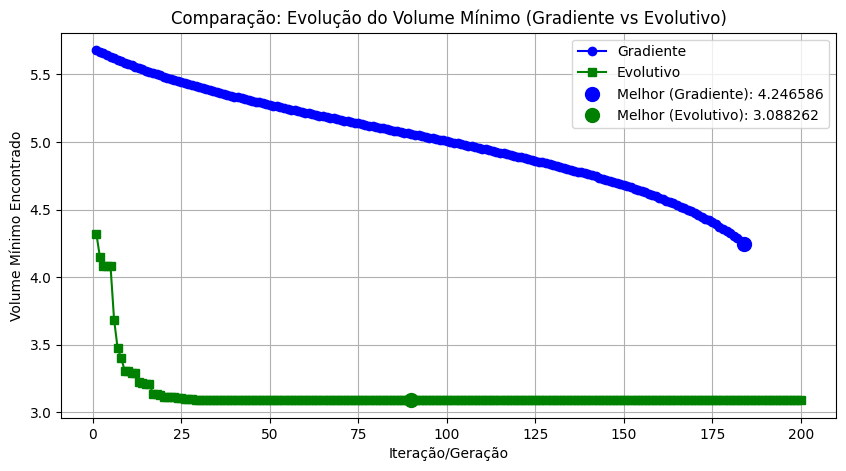

In [196]:
volumes_gradient = optimizeBifurcationGeometry_gradient(0, 0, max_iters = 200)
volumes_evolution = optimizeBifurcationGeometry_evolution(max_generations = 200)

plt.figure(figsize=(10, 5))

# Plota a evolu√ß√£o do volume para o m√©todo do gradiente
plt.plot(range(1, len(volumes_gradient) + 1), volumes_gradient, marker='o', linestyle='-', color='b', label="Gradiente")

# Plota a evolu√ß√£o do volume para o algoritmo evolutivo
plt.plot(range(1, len(volumes_evolution) + 1), volumes_evolution, marker='s', linestyle='-', color='g', label="Evolutivo")

# Destaca os menores volumes encontrados
min_volume_gradient = min(volumes_gradient)
min_idx_gradient = volumes_gradient.index(min_volume_gradient) + 1
plt.scatter(min_idx_gradient, min_volume_gradient, color='blue', s=100, label=f"Melhor (Gradiente): {min_volume_gradient:.6f}")

min_volume_evolution = min(volumes_evolution)
min_idx_evolution = volumes_evolution.index(min_volume_evolution) + 1
plt.scatter(min_idx_evolution, min_volume_evolution, color='green', s=100, label=f"Melhor (Evolutivo): {min_volume_evolution:.6f}")

# Configura√ß√µes do gr√°fico
plt.xlabel("Itera√ß√£o/Gera√ß√£o")
plt.ylabel("Volume M√≠nimo Encontrado")
plt.title("Compara√ß√£o: Evolu√ß√£o do Volume M√≠nimo (Gradiente vs Evolutivo)")
plt.legend()
plt.grid()
plt.show()

Como mostrado no gr√°fico, a curva azul representa a evolu√ß√£o do volume m√≠nimo encontrado pelo m√©todo de Gradiente. Observa-se que o algoritmo inicia com um valor superior a 5.5 e, ao longo de aproximadamente 200 itera√ß√µes, reduz o volume m√≠nimo at√© atingir um valor pr√≥ximo de 4.246586.

No gr√°fico, a curva verde mostra a evolu√ß√£o do volume m√≠nimo encontrado por esse m√©todo. Nota-se que a redu√ß√£o do volume ocorre de maneira muito r√°pida nas primeiras itera√ß√µes, atingindo rapidamente valores abaixo de 3.5 antes de estabilizar em torno de 3.088262.

Com base nos resultados do gr√°fico, o Algoritmo Evolutivo se mostrou superior para este problema espec√≠fico, atingindo um volume m√≠nimo menor (3.088262) em compara√ß√£o ao m√©todo de Gradiente (4.246586).

# Coclus√£o

Os resultados obtidos indicam que os Algoritmos Evolutivos possuem maior potencial para otimiza√ß√£o do volume m√≠nimo de √°rvores arteriais quando comparados ao m√©todo de Gradiente. A rapidez na converg√™ncia e a capacidade de escapar de m√≠nimos locais tornam essa abordagem mais promissora para problemas complexos, como a modelagem de sistemas biom√©dicos e redes vasculares.

Para trabalhos futuros, propomos a replica√ß√£o deste experimento em modelos mais avan√ßados, incluindo a otimiza√ß√£o de uma √°rvore arterial completa e a transi√ß√£o para um modelo tridimensional. A modelagem de uma √°rvore completa permitir√° avaliar como a estrutura global influencia a otimiza√ß√£o do volume m√≠nimo, enquanto a abordagem 3D fornecer√° uma representa√ß√£o mais realista do sistema arterial, aproximando-se ainda mais das condi√ß√µes encontradas em aplica√ß√µes biom√©dicas.

# Refer√™ncias


[1]. Rudolf Karch, Friederike Neumann, Martin Neumann e Wolfgang Schreiner. ‚ÄúA three-dimensional model for arterial tree representation, generated by constrained constructive optimization‚Äù. Em: Computers in Biology and Medicine 29.1 (1999), pp. 19‚Äì38. issn: 0010-4825. doi: 10.1016/S0010- 4825(98)00045- 6. url: https://doi.org/10.1016/S0010-4825(98)00045-6.




[2].   Rafael Alves Bonfim Queiroz. ‚ÄúConstru√ß√£o autom√°tica de modelos de √°rvores circulat√≥rias e suas aplica√ß√µes em hemodin√¢mica computacional‚Äù. Portuguese. Acesso Aberto. Tese de Doutorado. Petr√≥polis, RJ, Brasil: Programa de P√≥s-Gradua√ß√£o em Modelagem Computacional, Laborat√≥rio Nacional de Computa√ß√£o Cient√≠fica (LNCC), 2013. url: https://tede.lncc.br/handle/tede/170.

[3]. W. Schreiner e P.F. Buxbaum. ‚ÄúComputer-optimization of vascular trees‚Äù. Em: IEEE Transactions on Biomedical Engineering 40.5 (1993), pp. 482‚Äì491. doi: 10.1109/10.243413. url: https://doi.org/10.1109/10.243413.
